# Vehicle detection and tracking
## Pipeline summary
* Each frame of video, run a search for cars using a sliding window technique
* Wherever classifier returns a positive detection, record the position of the window that the detection was made
* For overlapping detections, assign the position of the detection to the centroid of the overlapping windows
* For false positives, filter out by detecting them as transients from one frame to the next
* Once a high confidence detection has been reached, record how the centroid moves from one frame to the next and predict centroids in subsequent frames

## Project tips
* Decide what features to use
 * Try combination of colour and gradient
 * Experiment
* Choose and train a classifer
 * Linear SVM for speed/accuracy
* Implement sliding window on test images
 * Try multi-scale search or different tiling schemes
 * Try to minimise number of search windows (ie ignore sky)
* With a working detection pipeline, move to video streams
 * Implement tracking and filter out spurious detections 

## Imports

In [1]:
import numpy as np
import cv2
from skimage import data
from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV

In [2]:
import glob
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage import exposure
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

from helper import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [28]:
images = glob.glob('train_images/*vehicles/*/*png')
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

[0 1 2 3]
range(0, 4)


## Dataset characterisation

Your function returned a count of 8792 cars and 9006 non-cars
of size: (64, 64, 3) and data type: float32


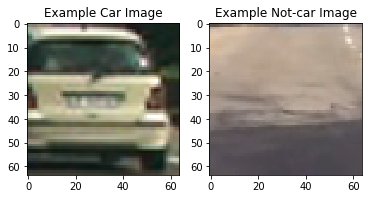

In [8]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], 'cars and', 
      data_info["n_notcars"], 'non-cars')
print('of size:', data_info["image_shape"], 'and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

## Colour channel histograms

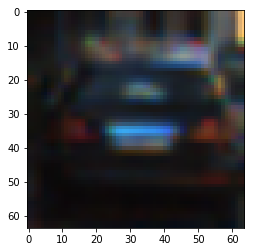

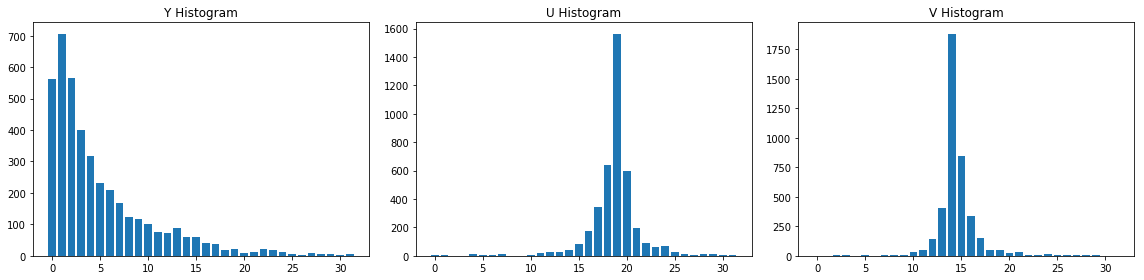

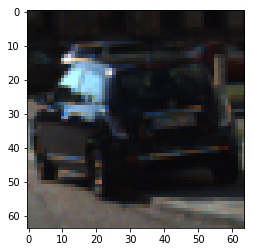

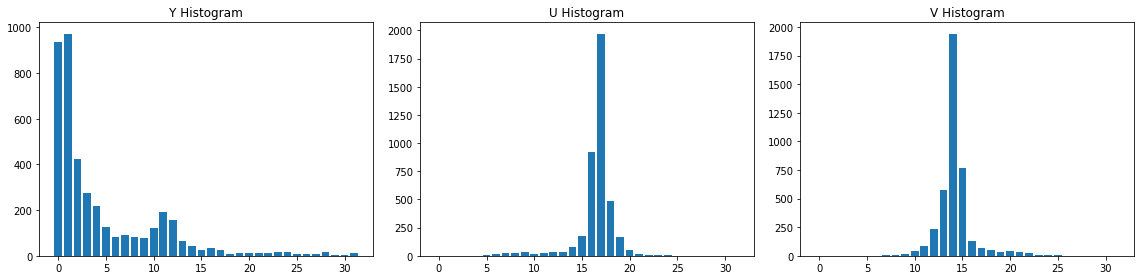

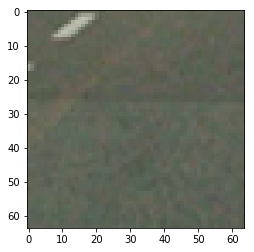

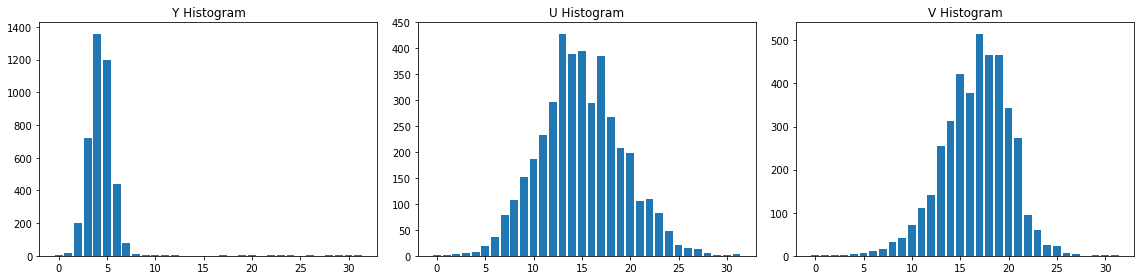

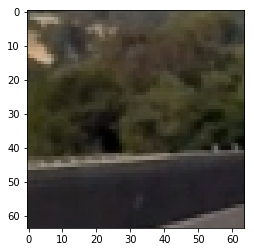

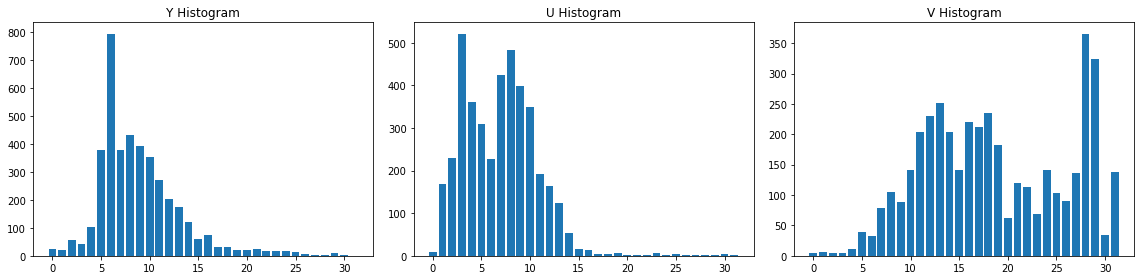

In [39]:
for file in np.concatenate((random.sample(cars,2), random.sample(notcars,2)), axis=0):
    mpimage = mpimg.imread(file)
    colorspace = ['Y', 'U', 'V']
    image = convert_colour(mpimage, 'RGB2YUV')

    features = color_hist(image)
    width = int(len(features)/3)
    
    # Plot a figure with all three bar charts
    plt.imshow(mpimage)
    fig = plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.bar(np.arange(width), features[:width])
    plt.title(colorspace[0]+' Histogram')
    plt.subplot(132)
    plt.bar(np.arange(width), features[width:width*2])
    plt.title(colorspace[1]+' Histogram')
    plt.subplot(133)
    plt.bar(np.arange(width), features[width*2:width*3])
    plt.title(colorspace[2]+' Histogram')
    fig.tight_layout()
    plt.show()

## Plotting colour spaces

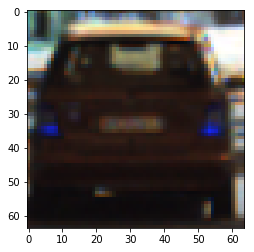

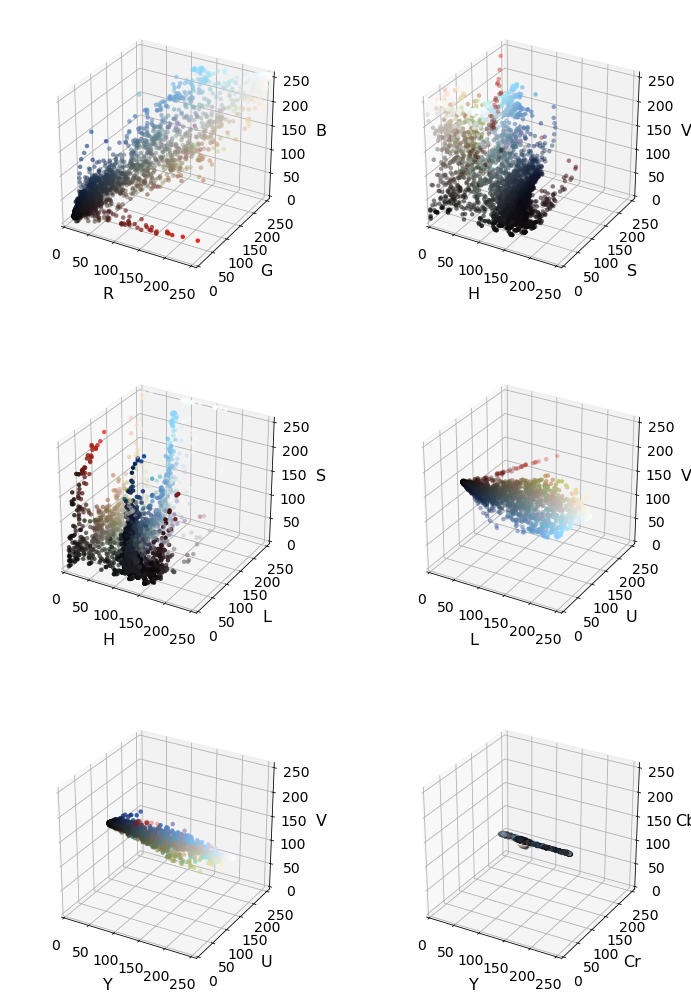

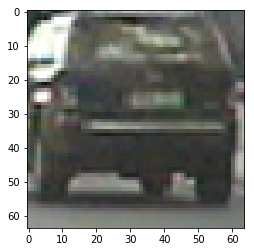

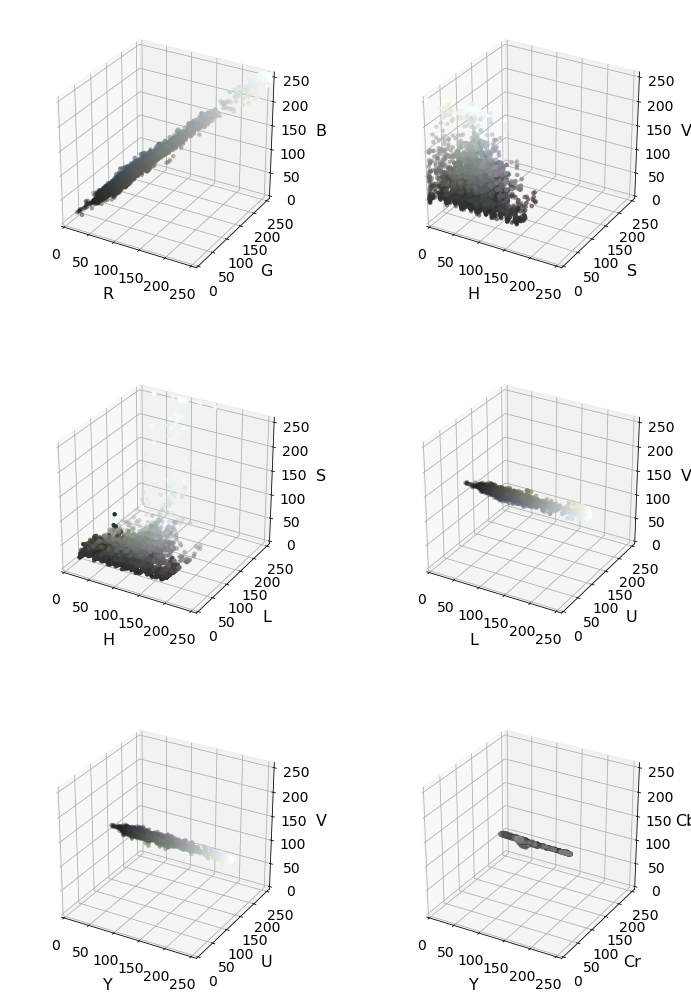

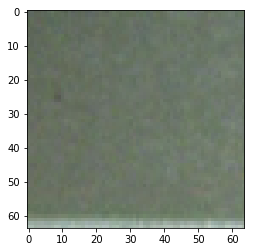

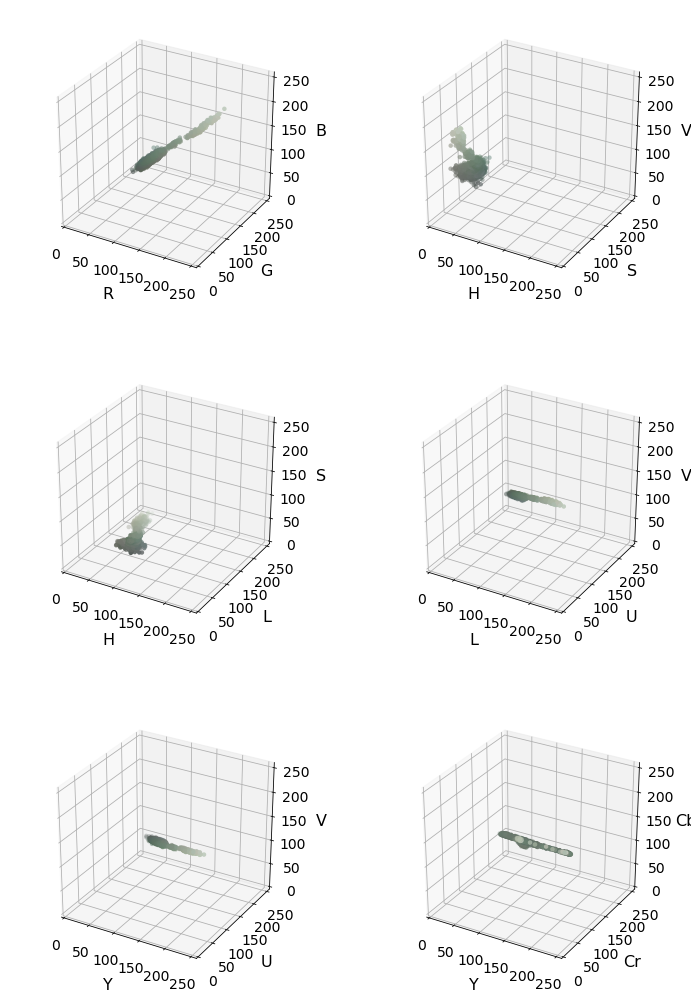

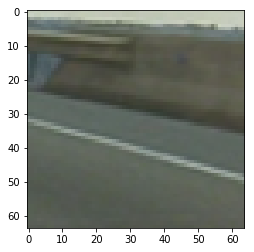

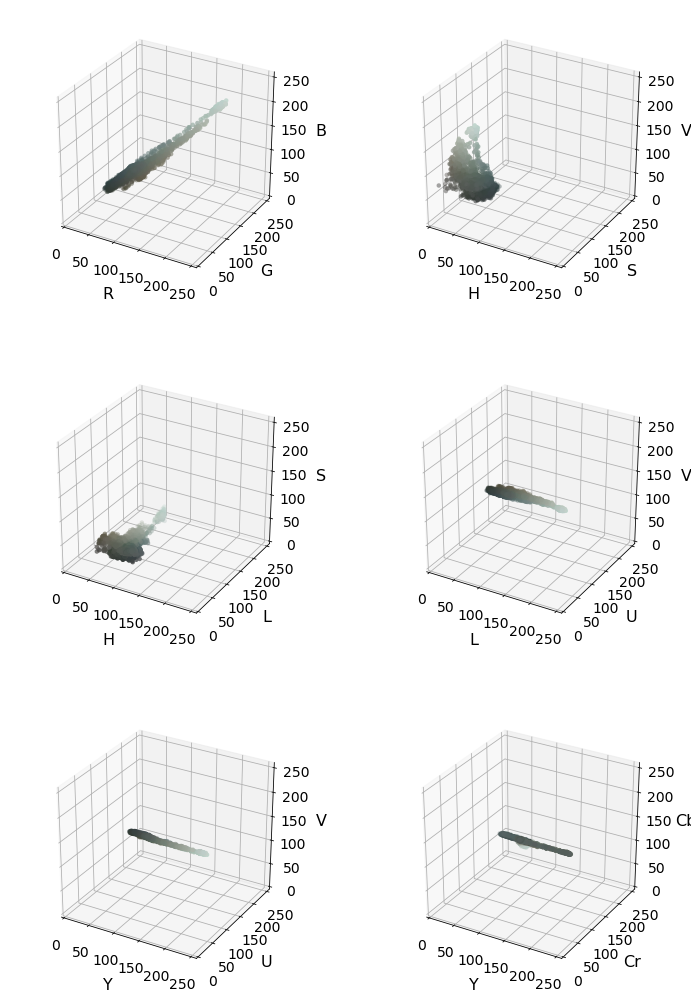

In [49]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255)), fig=None, pos=None):
    """Plot pixels in 3D.
    """
    # Create figure and 3D axes
    if fig is None:
        fig = plt.figure(figsize=(8, 8))
        ax = Axes3D(fig)
    else:
        ax = fig.add_subplot(pos[0], pos[1], pos[2], projection='3d')

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    
    ax.dist = 11

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

# Read a color image
for f in np.concatenate((random.sample(cars,2), random.sample(notcars,2)), axis=0):
    img_name = f.split('\\')[1]
    img = cv2.imread(f)

    # Convert subsampled image to desired color space(s)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV uses BGR, matplotlib likes RGB
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    img_LUV = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    img_YUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
    img_rgb = img_RGB / 255. # scaled to [0, 1], only for plotting

    # Plot and show
    plt.imshow(img)
    plt.show()
    fig = plt.figure(figsize=(12, 18))
    plot3d(img_RGB,   img_rgb,                                fig=fig, pos=(3,2,1))
    plot3d(img_HSV,   img_rgb, axis_labels=list("HSV"),       fig=fig, pos=(3,2,2))
    plot3d(img_HLS,   img_rgb, axis_labels=list("HLS"),       fig=fig, pos=(3,2,3))
    plot3d(img_LUV,   img_rgb, axis_labels=list("LUV"),       fig=fig, pos=(3,2,4))
    plot3d(img_YUV,   img_rgb, axis_labels=list("YUV"),       fig=fig, pos=(3,2,5))
    plot3d(img_YCrCb, img_rgb, axis_labels=("Y", "Cr", "Cb"), fig=fig, pos=(3,2,6))
    plt.show()

## Spatial binning of colour channels

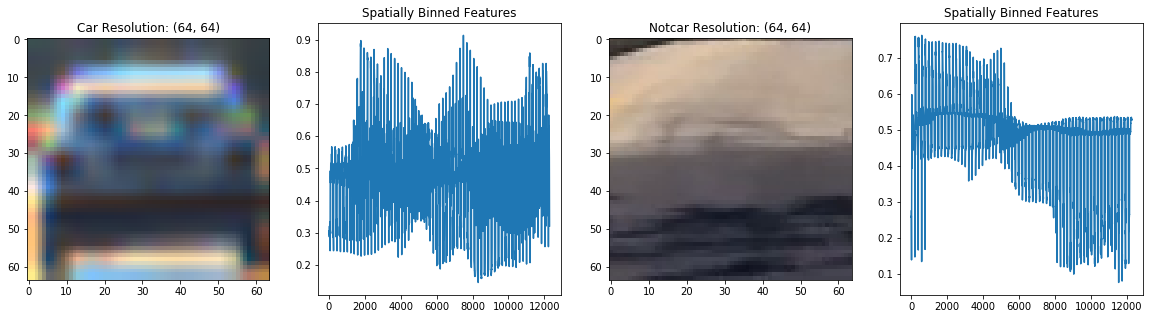

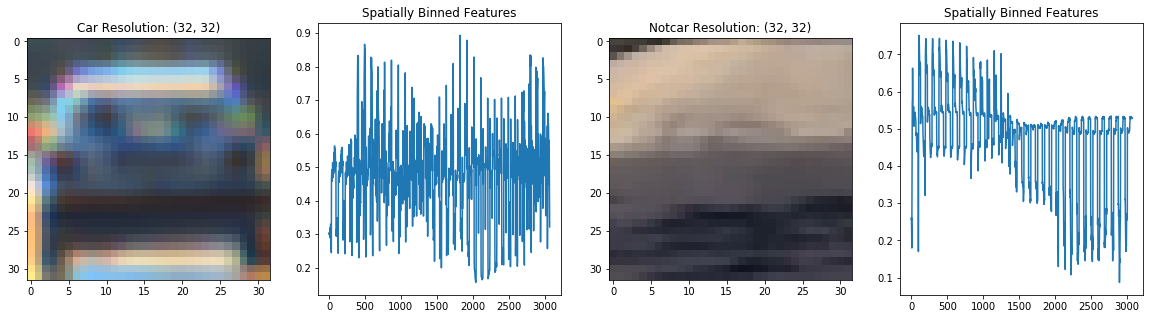

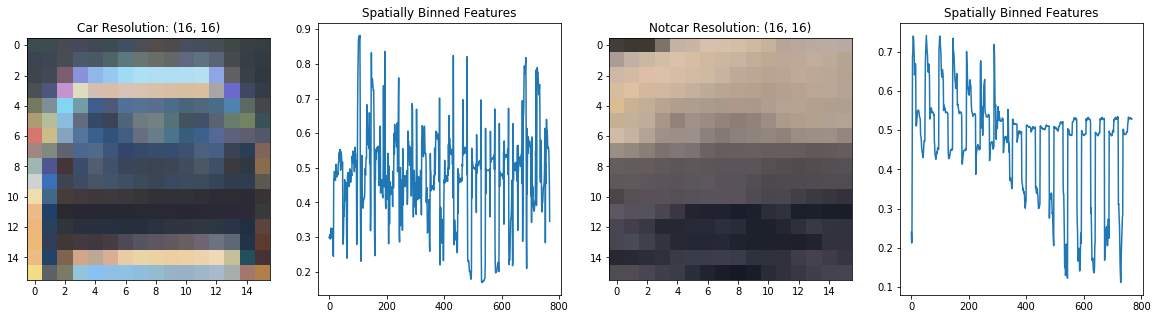

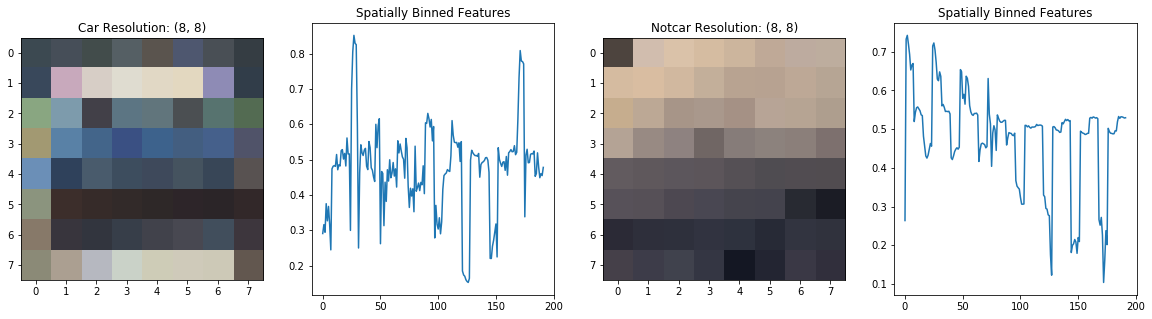

In [63]:
image_car = mpimg.imread(random.choice(cars))
image_notcar = mpimg.imread(random.choice(notcars))
imh=image_car.shape[0]
imw=image_car.shape[1]

for res in (1, 0.5, 0.25, 0.125):
    size = (int(imh*res), int(imw*res))
    
    feature_car = bin_spatial(image_car, 'RGB2YUV', size)
    feature_notcar = bin_spatial(image_notcar, 'RGB2YUV', size)
    
    # Plot features
    fig, ax = plt.subplots(1, 4, figsize=(20,5))
    ax[0].imshow(cv2.resize(image_car, size, cv2.INTER_LINEAR))
    ax[0].set_title('Car Resolution: ({}, {})'.format(size[0], size[1]))
    ax[1].plot(feature_car)
    ax[1].set_title('Spatially Binned Features')
    ax[2].imshow(cv2.resize(image_notcar, size, cv2.INTER_LINEAR))
    ax[2].set_title('Notcar Resolution: ({}, {})'.format(size[0], size[1]))
    ax[3].plot(feature_notcar)
    ax[3].set_title('Spatially Binned Features')
    plt.show()

## Histogram of Oriented Gradients (HOG)

In [64]:
features, hog_image = get_hog_features(car_image, 9, 4, 1, True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].axis('off')
ax[0].imshow(car_image, cmap=plt.cm.gray)
ax[0].set_title('Input image')
ax[0].set_adjustable('box-forced')

# Rescale histogram for better display
#hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax[1].axis('off')
ax[1].imshow(hog_image, cmap=plt.cm.gray)
ax[1].set_title('Histogram of Oriented Gradients')
ax[1].set_adjustable('box-forced')
plt.show()

NameError: name 'get_hog_features' is not defined

## Combine and normalise features

In [ ]:
#bin_spatial??
#color_hist??
#grad_hist??
extract_features?

In [ ]:
spatial_params = {
    'conv'      : 'RGB2LUV',
    'size'      : (64, 64),
    'visualise' : False
}

hoc_params = {
    'conv'        : 'RGB2HSV',
    'bins'        : 32,
    'brange'      : (0, 256),
    'concatenate' : True
}

hog_params = {
    'conv'           : 'RGB2LUV',
    'channels'       : [1, 2],
    'orientations'   : 9,
    'pix_per_cell'   : 8,
    'cell_per_block' : 3
}

car_features = extract_features(cars, spatial_params, hoc_params, hog_params)
notcar_features = extract_features(notcars, spatial_params, hoc_params, hog_params)

for i in range(4):
    # Just for fun choose random car / not-car indices and plot example images
    if i < 2:
        ind = np.random.randint(0, len(cars))
        image = mpimg.imread(cars[ind])
    else:
        ind = np.random.randint(0, len(notcars))
        image = mpimg.imread(notcars[ind])
        ind += len(car_features)

    # Create an array stack of feature vectors
    #np.vstack??
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    #X_scaler = StandardScaler().fit(X)
    #X_scaler = MinMaxScaler().fit(X)
    X_scaler = RobustScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original Image: '+str(ind))
    plt.subplot(132)
    plt.plot(X[ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[ind])
    plt.title('Normalized Features')
    fig.tight_layout()

## Parameter tuning
### Using Scikit-learn Cross Validation

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()

parameters = {'kernel':('linear', 'rbf'), 'C':[0.5, 1, 2, 5, 10]}
svr = SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(iris.data, iris.target)
print('The best params are:', clf.best_params_)

---
## Training a classifier
**Warning** When dealing with image data that was extracted from video, you may be dealing with sequences of images where your target object (vehicles in this case) appear almost identical in a whole series of images. In such a case, even a randomized train-test split will be subject to overfitting because images in the training set may be nearly identical to images in the test set. For the subset of images used in the next several quizzes, this is not a problem, but to optimize your classifier for the project, you may need to worry about time-series of images!
### Using color

In [ ]:
# Play with these values to see how your classifier
# performs under different binning scenarios
spatial = 16
histbin = 32



t=time.time()
car_features = extract_features(cars, spatial_params, hoc_params, hog_params)
notcar_features = extract_features(notcars, spatial_params, hoc_params, hog_params)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract colour features...')

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

### Using HOG

In [ ]:
### Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

## Siding windows

shape: (720, 1280, 3)
span (x, y): 1280 220
pixels per step (x, y): 64 64
num windows (x, y): 19 2


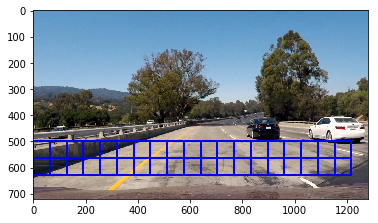

0.35 Seconds to train SVC...


In [67]:
t = time.time()
image = mpimg.imread('test_images/test1.jpg')
windows = slide_window(image, y_start_stop=(500, 720),  xy_window=(64, 64),
                       xy_overlap=(0, 0), show_stats=True)

window_img = draw_boxes(image, windows, colour=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

## Search and classify
* Train classifier
* Perform sliding window
* Extract features
* Predict if each window has a car or now

*In this exercise, experiment with different color and gradient feature sets, different search window sizes and overlap to get an idea of how your classifier performs with different training features. Getting false positives in the skies and treetops? Try restricting your search area on the image with y_start_stop in the slide_window() function. What combination of features works best?*

In [68]:
"""
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 5 # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
"""


spatial_params = {
    'conv'      : 'RGB2LUV',
    'size'      : (32, 32),
    'visualise' : False
}

hoc_params = {
    'conv'        : 'RGB2HSV',
    'bins'        : 16,
    'brange'      : (0, 256),
    'concatenate' : True
}

hog_params = {
    'conv'           : 'RGB2LUV',
    'channels'       : [1, 2],
    'orientations'   : 9,
    'pix_per_cell'   : 8,
    'cell_per_block' : 3
}

t=time.time()
car_features = extract_features(cars, None, None, hog_params)
notcar_features = extract_features(notcars, None, None, hog_params)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
X_scaler = RobustScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',hog_params['orientations'],'orientations',hog_params['pix_per_cell'],
    'pixels per cell and', hog_params['cell_per_block'],'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()




74.17 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 5832
35.65 Seconds to train SVC...
Test Accuracy of SVC =  0.9508


FileNotFoundError: [Errno 2] No such file or directory: 'test_images/bbox-example-image.jpg'

In [ ]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = []
for search_param in (((500, 720), (32, 32)),
                     ((500, 720), (64, 64)),
                     ((500, 720), (128, 128))):
    y_start_stop = search_param[0]
    size = search_param[1]
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                           xy_window=size, xy_overlap=(0.5, 0.5)))

hot_windows = search_windows(image, windows, svc, X_scaler, None,
                             None, hog_params)

window_img = draw_boxes(draw_image, hot_windows)

fig = plt.figure(figsize=(20,10))
plt.imshow(window_img)
plt.show()

## HOG sub-sampling window search
More efficient sliding windows approach where hog features are extracted only once

`find_cars` only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [ ]:
# A single function that can extract features
# using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img


dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('test_image.jpg')

ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

## Multiple detections and false positives
### Using heatmaps and labels

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
#image = mpimg.imread('test_image.jpg')
image = mpimg.imread('test_images/bbox-example-image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(212)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
